# VAE

- 元論文 Auto-Encoding Variational Bayes https://arxiv.org/abs/1312.6114 (2013)

AutoEncoderの構造にEncoderとDecoderの中間での出力を特定の確率分布に近似させるのが**VAE(Variational Auto Encoder)**。

雑に言っちゃえばこんな感じ。この中間のパラメータを **潜在変数** と呼んだりする。 

```bash
Input X -> Encoder -> p(z|x) -> Decoder X
```
<img src='assets/vae.png' width=400>

VAEでは確率分布（黄色）を平均μ, 標準偏差σのガウス分布で近似する。つまり、Encoderでは最後にMLPを２つ用意し、それぞれの出力をμとσとして扱う。Decoderの入力にはN(μ, σ)からサンプリングしたノイズzをMLPでデコードする。

```bash
Input X -> Encoder ->  mu    ->   z ~N(mu, sigma) -> Decoder -> X
                         |-----> sigma  -----------------^
```
<img src='assets/vae_3.png' width=400>

だけど、ガウス分布からサンプリングするネットワークを組むと、学習（誤差の逆伝搬）ができなくなる。そこで、Parameterization Trickという方法を使う。Parameterization Trickでは、サンプリングする代わりに、μとσから直接的にzを求める。zは次式で計算される。

εは平均0、標準偏差1のガウス分布からサンプリングするものだけど、Encoderへの逆伝搬には影響しない。

$
z = \mu + \epsilon e^{0.5 + \sigma}, \epsilon \sim N(0, 1)
$

つまり、 VAEの全体的な構造はこうなる。ここでは潜在変数を２次元にしている。（MNISTでは２次元でなんとかなるが、Cifar10のように画像の分散が大きくなると、潜在変数も大きくする必要がある）

```bash
Input (784) -> Linear (256) -> Linear(2) -> Linear(2) -> Linear(256) -> Output(784)
                             |-------------> Linear(2)  --------^

```

<img src='assets/vae_2.png' width=400>

VAE の Loss は *Reconstruction Loss* と *KLDivergence* の２つの Multi task loss になる。 LreconstructionはAutoEncoderのロス（画像を復元するための入力画像と出力画像のCrossEntropy)。KLDは潜在変数をある特定の値に近づけるために導入されている。

ここでは潜在変数となるμ、σをそれぞれ0,1に近づけるために次式で定義される。

$ Loss = L_{Reconstruction} + D_{KL}$

$D_{KL} = - \frac{1}{2}(1 + \sigma - \mu^2 - e^{\sigma})$


## Import and Config

In [57]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from _main_base import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = 10

# model
cfg.INPUT_HEIGHT = 28
cfg.INPUT_WIDTH = 28
cfg.INPUT_CHANNEL = 1
cfg.INPUT_MODE = None # None, RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_HEIGHT = 28
cfg.OUTPUT_WIDTH = 28
cfg.OUTPUT_CHANNEL = 1
cfg.OUTPUT_MODE = None  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_CMAP = 'gray' # matplotlib cmap  (default : None)

# AE config
cfg.VAE_Z_DIM = 2
cfg.AE_DIM = 32 # AE encodes feature to this
cfg.AE_STACK_NUM = 2 # AE stack number, e.g. Input > encoder 1 > encoder 2 > ... > encoder this
cfg.AE_DIM_EXPAND_BASE = 2 # AE : layer output = AE_DIM * (AE_DIM_EXPAND_BASE ** N (encoder or decoder stage))
cfg.VAE_KLD_BALANCE = 1 # loss = lossReconstruction + this * loss_KLD

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()

cfg.PREFIX = 'VAE_mnist'
cfg.TRAIN.MODEL_E_SAVE_PATH = 'models/' + cfg.PREFIX + '_E_{}.pt' # save model to this path
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt' # save model to this path
cfg.TRAIN.MODEL_SAVE_INTERVAL = 10_000 # save model in each this
cfg.TRAIN.ITERATION = 100_000 # max training iteration
cfg.TRAIN.MINIBATCH = 512
cfg.TRAIN.OPTIMIZER = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.001, 'weight_decay' : 1e-5}
cfg.TRAIN.LOSS_FUNCTION = torch.nn.MSELoss(reduction='sum')

cfg.TRAIN.DATA_PATH = './data/' # use this dataset path
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.DISPLAY_ITERATION_INTERVAL = 1000
cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL = 10 # save loss in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW = 1000 # integer , False (not show)
cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True # save result image and loss text
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 10_000 # save image and loss text in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'


# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_E_PATH = cfg.TRAIN.MODEL_E_SAVE_PATH.format('final') # use this trained path
cfg.TEST.MODEL_D_PATH = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final') # use this trained path
cfg.TEST.DATA_PATH = './data' # use this dataset path
cfg.TEST.MINIBATCH = 10
cfg.TEST.MAX_SAMPLES = 100
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_E_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)


## Define Model

In [58]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class VAE_Encoder(torch.nn.Module):
    def __init__(self):
        super(VAE_Encoder, self).__init__()
        _layer_dim = max(cfg.AE_DIM * (cfg.AE_DIM_EXPAND_BASE ** (cfg.AE_STACK_NUM - 1)), cfg.AE_DIM)
        
        # Encoder
        module = OrderedDict({
            'encoder_flatten' : Flatten(),
            'encoder_1_layer' : torch.nn.Linear(cfg.INPUT_HEIGHT * cfg.INPUT_WIDTH * cfg.INPUT_CHANNEL, _layer_dim),
            'encoder_1_activation' : torch.nn.ReLU()
        })
        
        print('-' * 20 + '\nVAE Encoder')
        print('- Input : {} x {} x {}'.format(cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH, cfg.INPUT_CHANNEL))
        print('- encoder 1 : {} > {}'.format(cfg.INPUT_HEIGHT * cfg.INPUT_WIDTH * cfg.INPUT_CHANNEL, _layer_dim))
        
        for i in range(2, cfg.AE_STACK_NUM + 1):
            module['encoder_{}_layer'.format(i)] = torch.nn.Linear(_layer_dim, _layer_dim // cfg.AE_DIM_EXPAND_BASE)
            module['encoder_{}_activation'.format(i)] = torch.nn.ReLU()      
            print('- encoder {} : {} > {}'.format(i, _layer_dim, _layer_dim // cfg.AE_DIM_EXPAND_BASE))
            _layer_dim //= cfg.AE_DIM_EXPAND_BASE
            
        self.module = torch.nn.Sequential(module)
            
        self.encoder_mu = torch.nn.Linear(_layer_dim, cfg.VAE_Z_DIM)
        self.encoder_sigma = torch.nn.Linear(_layer_dim, cfg.VAE_Z_DIM)
        
        print('- encoder output : {} > {}'.format( _layer_dim, cfg.VAE_Z_DIM))
        
    def forward(self, x):
        x = self.module(x)
        mu = self.encoder_mu(x)
        sigma = self.encoder_sigma(x)
        return mu, sigma
    
    
class VAE_Sampler(torch.nn.Module):
    def __init__(self):
        super(VAE_Sampler, self).__init__()
        
    def forward(self, x):
        mu, sigma = x
        mb, _ = mu.size()
        epsilon = torch.tensor(np.random.normal(0, 1, [mb, cfg.VAE_Z_DIM]), dtype=torch.float32).to(cfg.DEVICE)
        std = torch.exp(0.5 * sigma)
        sample_z = mu + epsilon * std
        return sample_z
    
    
class VAE_Decoder(torch.nn.Module):
    def __init__(self):
        super(VAE_Decoder, self).__init__()
        _layer_dim = cfg.AE_DIM
        
        module = OrderedDict({
            'decoder_input' : torch.nn.Linear(cfg.VAE_Z_DIM, _layer_dim),
            'decoder_input_activation' : torch.nn.ReLU()
        })
        
        print('-' * 20 + '\nVAE Decoder')
        print('- Input : {}'.format(cfg.VAE_Z_DIM))
  
        for i in range(cfg.AE_STACK_NUM, 1, -1):
            module['decoder_{}_layer'.format(i)] = torch.nn.Linear(_layer_dim, _layer_dim * cfg.AE_DIM_EXPAND_BASE)
            module['decoder_{}_activation'.format(i)] = torch.nn.ReLU()
            print('- decoder {} : {} > {}'.format(i, _layer_dim, _layer_dim * cfg.AE_DIM_EXPAND_BASE))
            _layer_dim *= cfg.AE_DIM_EXPAND_BASE
            
        module['decoder_1'] = torch.nn.Linear(_layer_dim, cfg.OUTPUT_HEIGHT * cfg.OUTPUT_WIDTH * cfg.OUTPUT_CHANNEL)
        module['decoder_out_activation'] = torch.nn.Tanh()
        
        print('- decoder 1 : {} > {}'.format(_layer_dim, cfg.OUTPUT_HEIGHT * cfg.OUTPUT_WIDTH * cfg.OUTPUT_CHANNEL))
        print('- Output : ({} x {} x {})'.format(cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH, cfg.OUTPUT_CHANNEL))
        print('-' * 20)

        self.module = torch.nn.Sequential(module)
        
        
    def forward(self, x):
        x = self.module(x)
        #x = self.dec_out(x)
        #x = torch.sigmoid(x)
        return x

def loss_KLDivergence(mu, sigma):
    return - 0.5 * torch.sum(1 + sigma - torch.pow(mu, 2) - torch.exp(sigma))


## Utility

In [59]:
def result_show(model, Xs, path=None, save=False, show=False, figsize=(12, 4), cmap=None):
    _Xs = Xs.detach().cpu().numpy()
    _Xs = (_Xs * 127.5 + 127.5).astype(np.uint8)
    
    ys = model(Xs).detach().cpu().numpy()
    ys = (ys * 127.5 + 127.5).astype(np.uint8)
    ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    
    if cfg.OUTPUT_CHANNEL == 1:
        _Xs = _Xs[:, 0]
        ys = ys[:, 0]
    else:
        _Xs = _Xs.transpose(0, 2, 3, 1)
        ys = ys.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(ys))
        
    plt.figure(figsize=figsize)
    for i in range(show_max):
        # show input
        _X = _Xs[i]
        plt.subplot(2, show_max, i + 1)
        plt.imshow(_X, cmap=cmap)
        plt.axis('off')
        plt.title('Input{}'.format(i + 1))
        
        # show output
        _y = ys[i]
        plt.subplot(2, show_max, i + 1 + show_max)
        plt.imshow(_y, cmap=cmap)
        plt.axis('off')
        plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

## Train

--------------------
VAE Encoder
- Input : 28 x 28 x 1
- encoder 1 : 784 > 64
- encoder 2 : 64 > 32
- encoder output : 32 > 2
--------------------
VAE Decoder
- Input : 2
- decoder 2 : 32 > 64
- decoder 1 : 64 > 784
- Output : (28 x 28 x 1)
--------------------
training data :  (60000, 28, 28)
training start
Iter:1000, Loss:79858.9219 (Recon:77146.6797, KLD:2712.2419)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

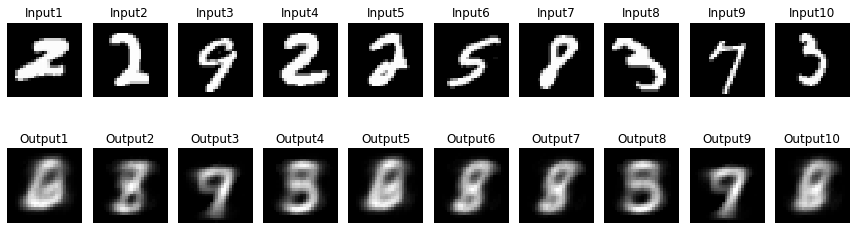

Iter:2000, Loss:77267.5000 (Recon:74409.9766, KLD:2857.5271)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

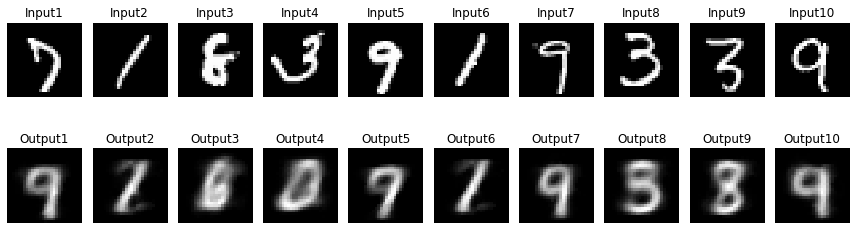

Iter:3000, Loss:72496.4375 (Recon:69488.1953, KLD:3008.2446)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

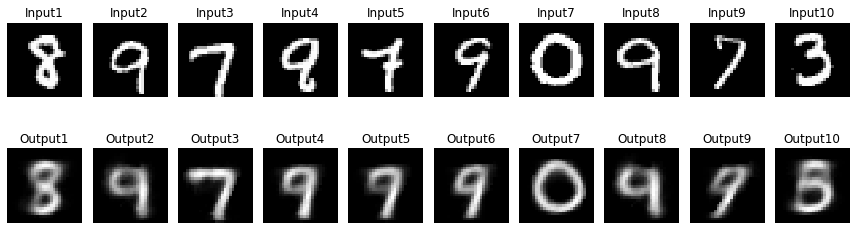

Iter:4000, Loss:71160.3828 (Recon:68036.3359, KLD:3124.0442)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

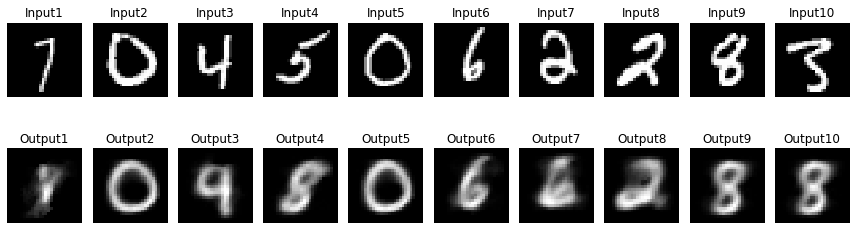

Iter:5000, Loss:70985.2969 (Recon:67770.7812, KLD:3214.5156)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

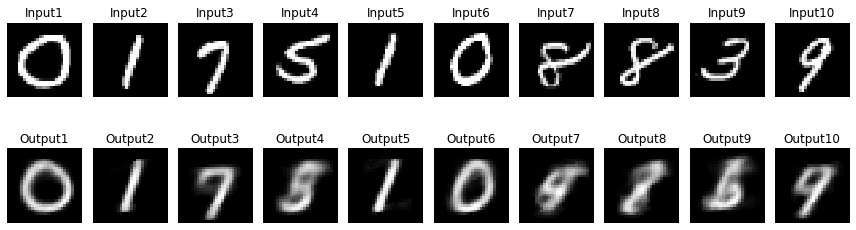

Iter:6000, Loss:71125.7969 (Recon:68004.9766, KLD:3120.8208)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

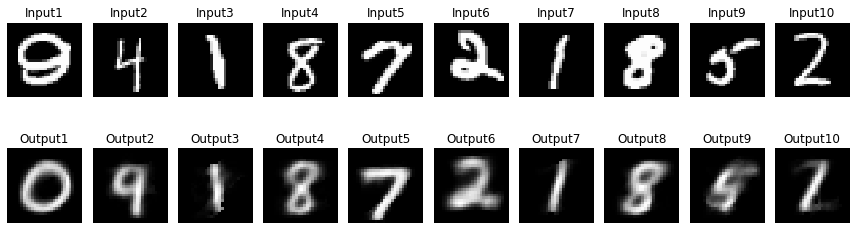

Iter:7000, Loss:68732.8828 (Recon:65447.2734, KLD:3285.6064)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

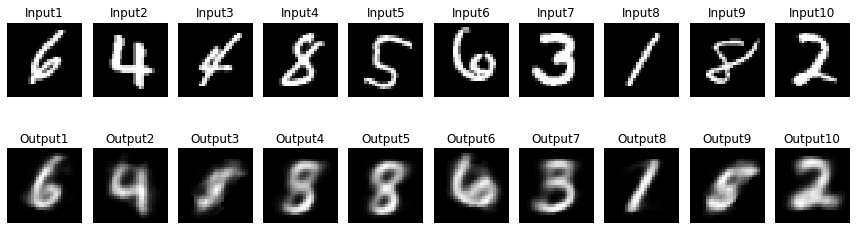

Iter:8000, Loss:68880.4297 (Recon:65697.3750, KLD:3183.0518)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

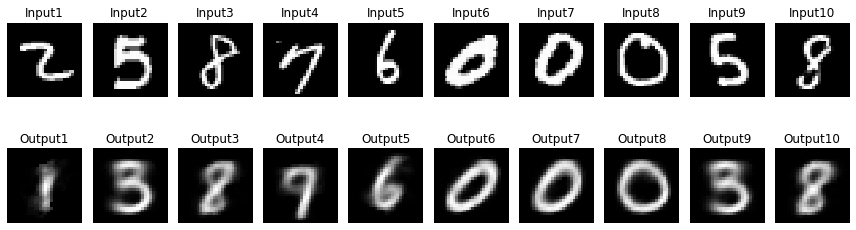

Iter:9000, Loss:69550.6328 (Recon:66231.6562, KLD:3318.9749)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

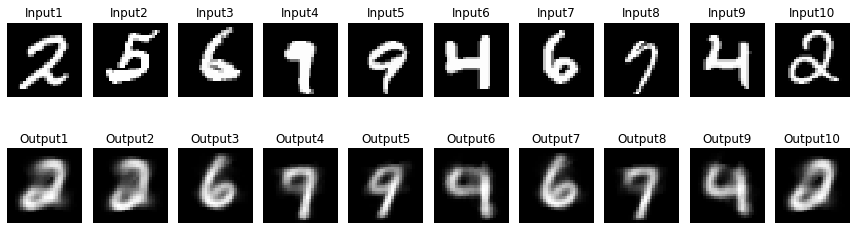

Iter:10000, Loss:69657.2578 (Recon:66346.4766, KLD:3310.7803)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

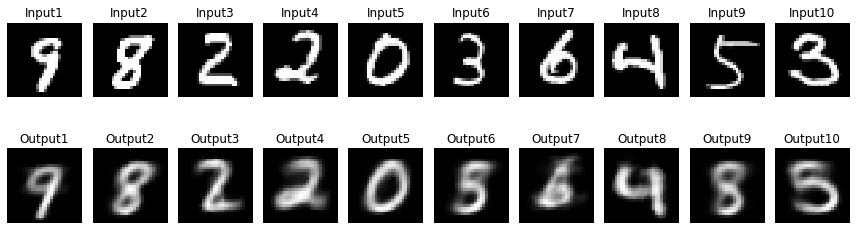

result was saved to >> result/VAE_mnist_result_iter10000.jpg
Iter:11000, Loss:69192.9922 (Recon:65860.9688, KLD:3332.0242)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

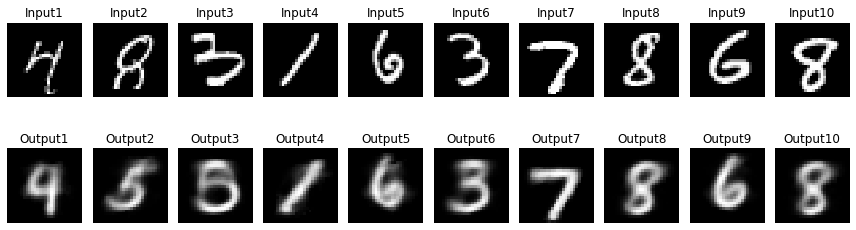

Iter:12000, Loss:67651.0469 (Recon:64353.4883, KLD:3297.5601)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

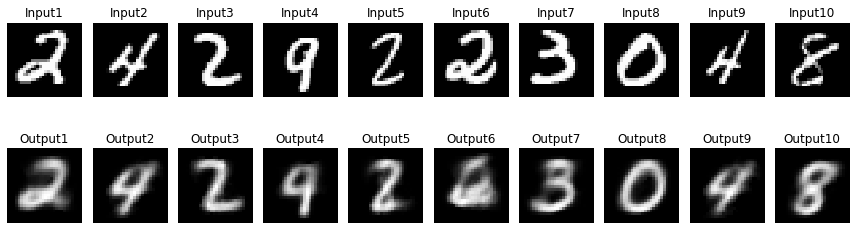

Iter:13000, Loss:68291.6562 (Recon:64920.1328, KLD:3371.5200)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

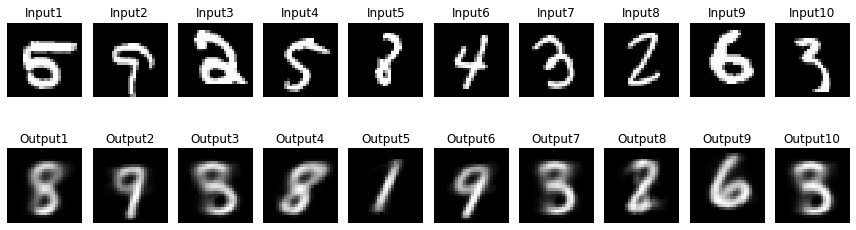

Iter:14000, Loss:66660.6797 (Recon:63349.4688, KLD:3311.2112)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

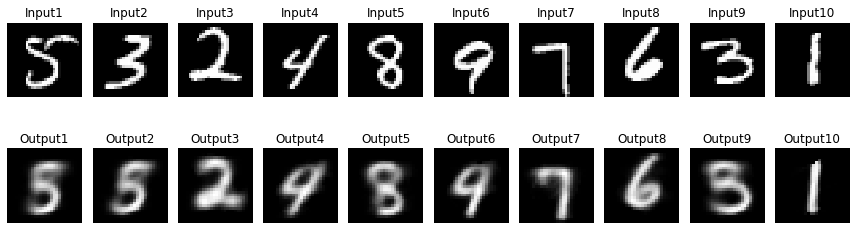

Iter:15000, Loss:67031.7656 (Recon:63637.3516, KLD:3394.4116)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

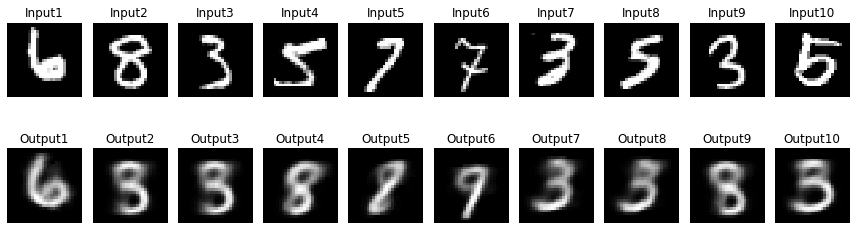

Iter:16000, Loss:66549.2344 (Recon:63166.5664, KLD:3382.6697)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

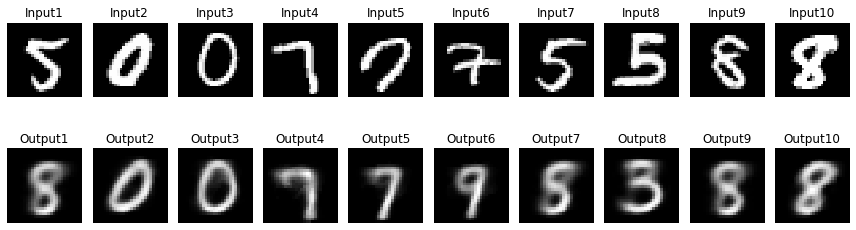

Iter:17000, Loss:65915.1797 (Recon:62525.2930, KLD:3389.8850)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

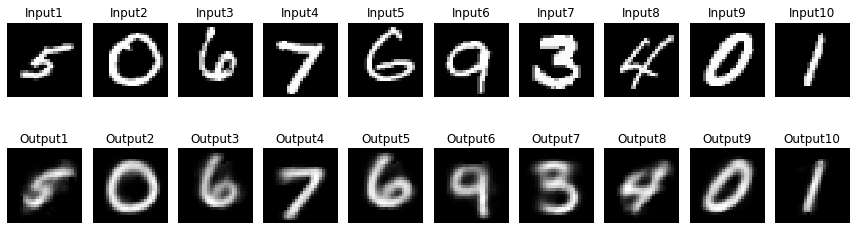

Iter:18000, Loss:66983.1328 (Recon:63571.3633, KLD:3411.7729)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

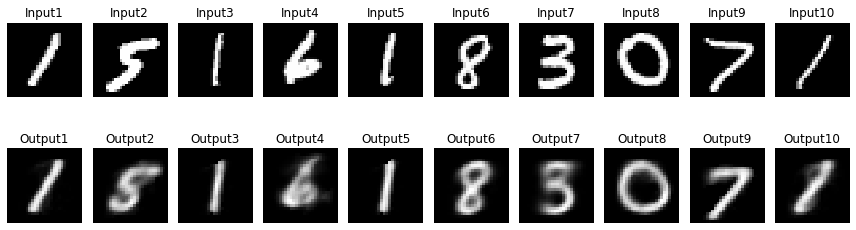

Iter:19000, Loss:66454.9297 (Recon:63019.5234, KLD:3435.4038)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

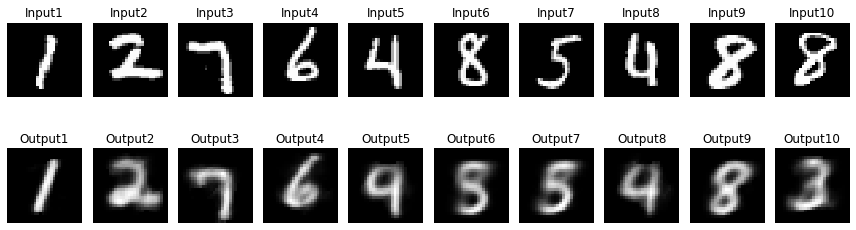

Iter:20000, Loss:66144.6406 (Recon:62754.3008, KLD:3390.3369)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

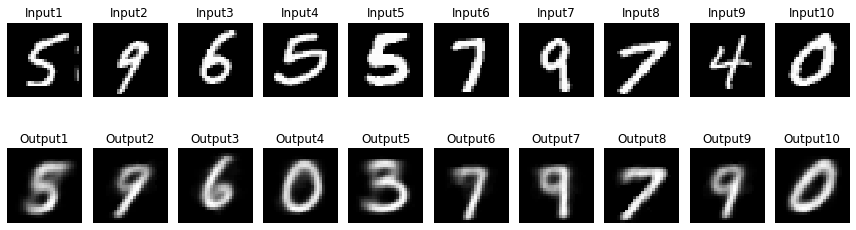

result was saved to >> result/VAE_mnist_result_iter20000.jpg
Iter:21000, Loss:63021.1289 (Recon:59578.7695, KLD:3442.3584)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

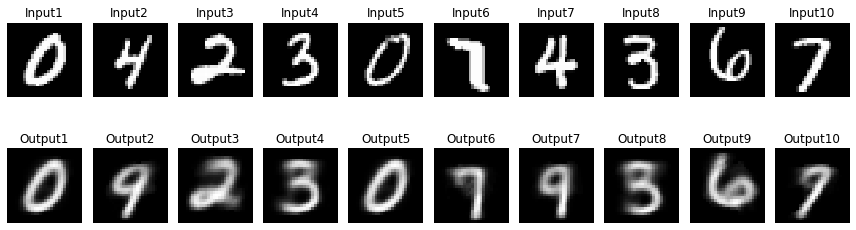

Iter:22000, Loss:65442.9922 (Recon:61990.9844, KLD:3452.0068)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

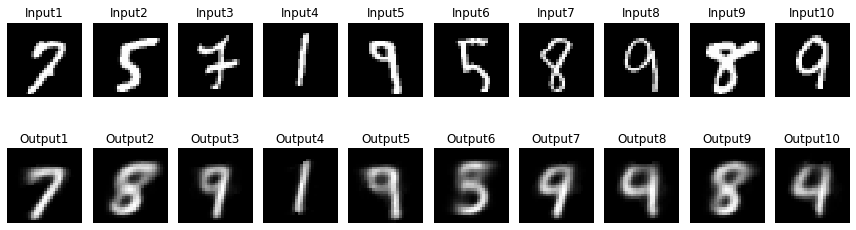

Iter:23000, Loss:66261.1328 (Recon:62824.8320, KLD:3436.3044)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

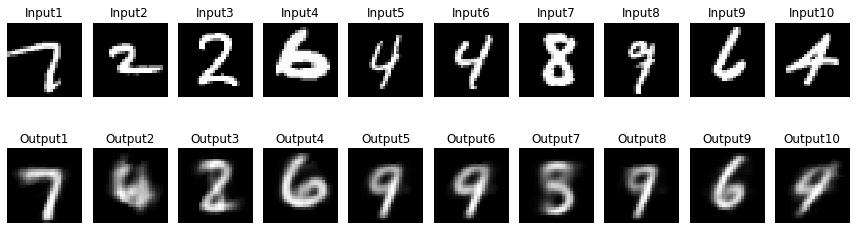

Iter:24000, Loss:64589.0391 (Recon:61077.7109, KLD:3511.3276)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

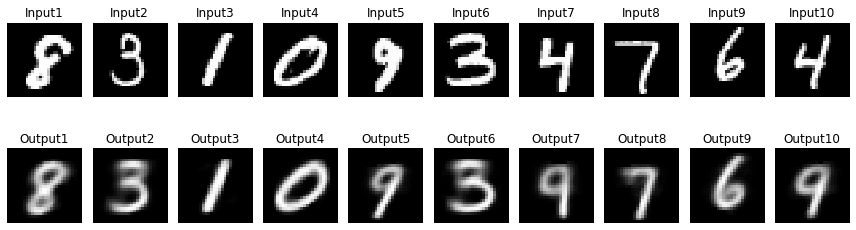

Iter:25000, Loss:65693.6094 (Recon:62223.4727, KLD:3470.1340)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

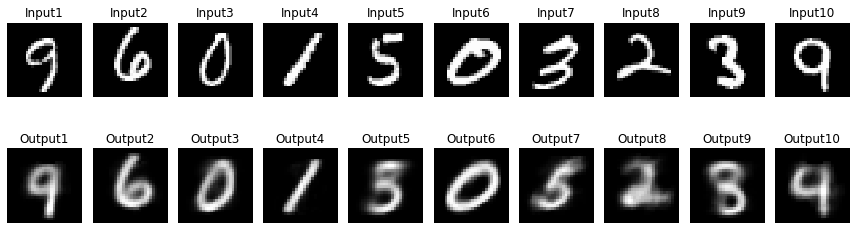

Iter:26000, Loss:62994.4883 (Recon:59503.4023, KLD:3491.0859)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

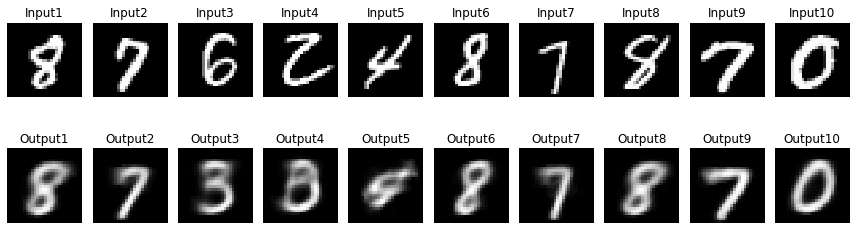

Iter:27000, Loss:65872.6016 (Recon:62387.6523, KLD:3484.9475)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

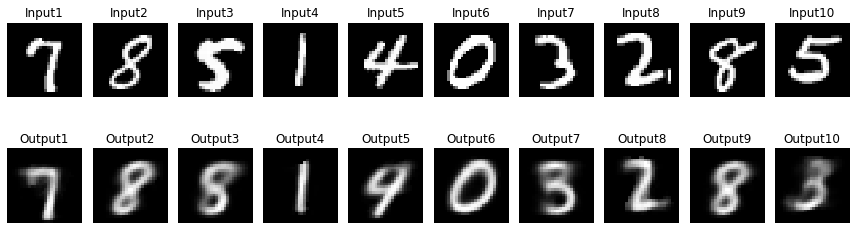

Iter:28000, Loss:64124.0391 (Recon:60588.2656, KLD:3535.7747)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

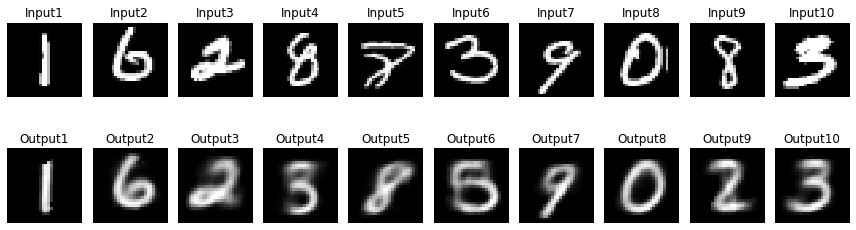

Iter:29000, Loss:65173.3125 (Recon:61604.3750, KLD:3568.9377)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

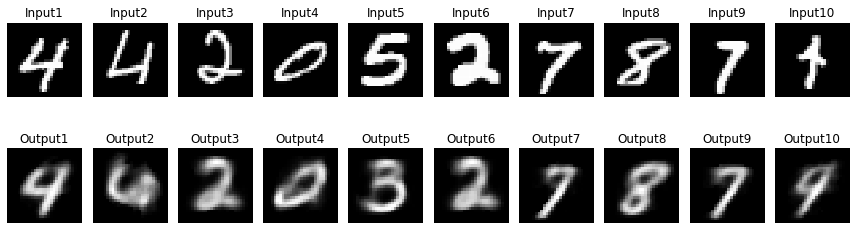

Iter:30000, Loss:65464.0000 (Recon:61856.7305, KLD:3607.2700)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

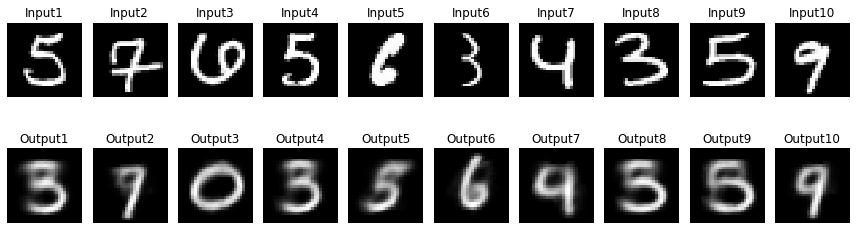

result was saved to >> result/VAE_mnist_result_iter30000.jpg
Iter:31000, Loss:65242.4297 (Recon:61701.5898, KLD:3540.8386)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

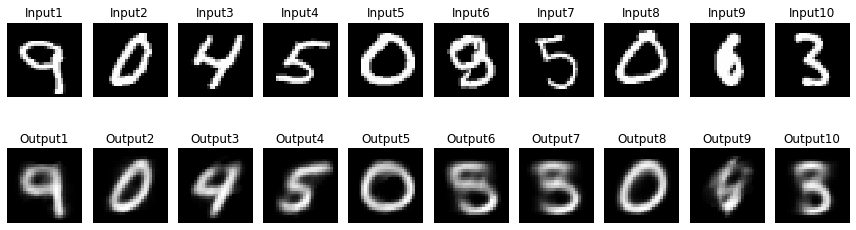

Iter:32000, Loss:65997.2344 (Recon:62509.1250, KLD:3488.1118)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

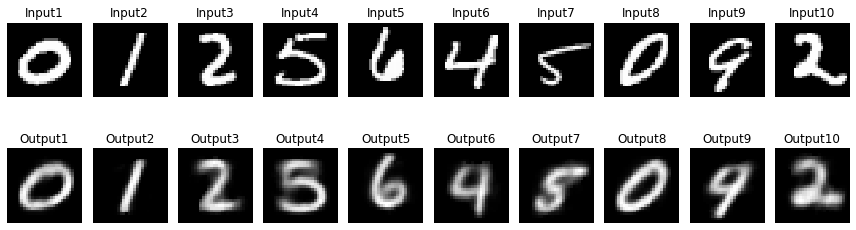

Iter:33000, Loss:65502.3984 (Recon:61900.6758, KLD:3601.7219)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

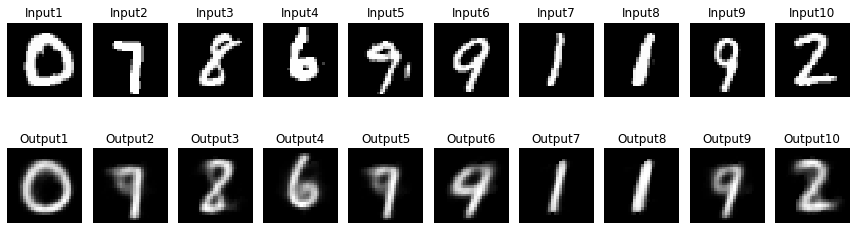

Iter:34000, Loss:66306.9062 (Recon:62756.5469, KLD:3550.3608)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

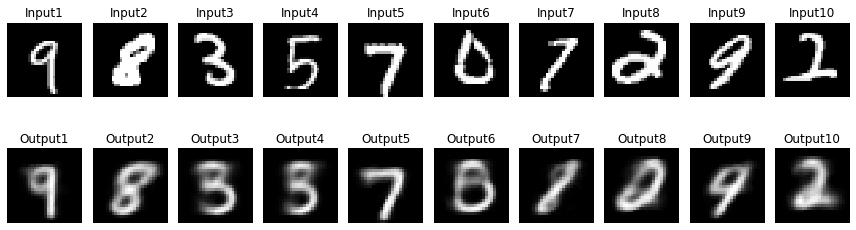

Iter:35000, Loss:66340.0547 (Recon:62782.3633, KLD:3557.6948)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

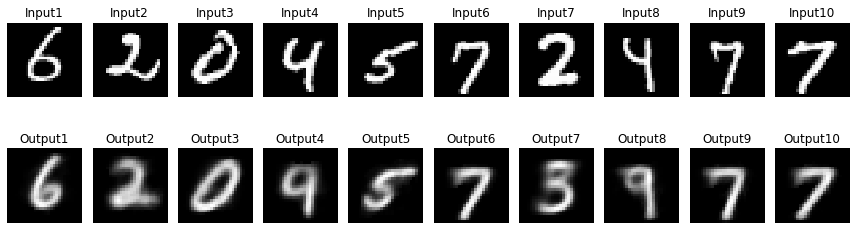

Iter:36000, Loss:64329.5117 (Recon:60822.1016, KLD:3507.4092)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

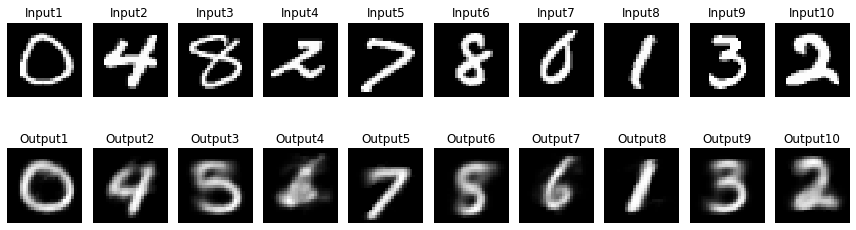

Iter:37000, Loss:67632.0000 (Recon:64033.2617, KLD:3598.7412)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

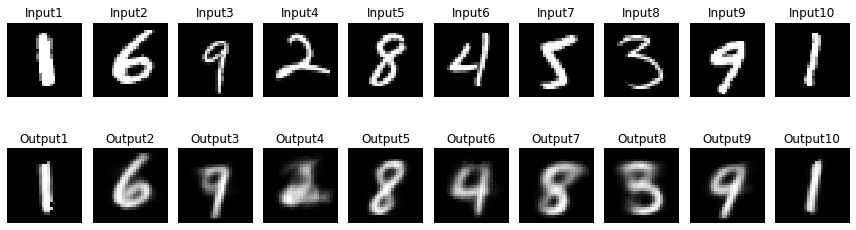

Iter:38000, Loss:65540.0547 (Recon:62014.8164, KLD:3525.2419)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

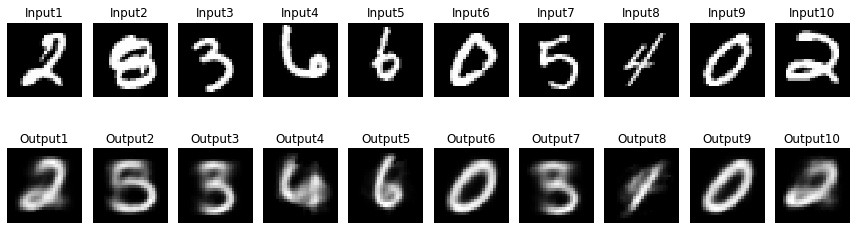

Iter:39000, Loss:66378.2891 (Recon:62858.0312, KLD:3520.2561)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

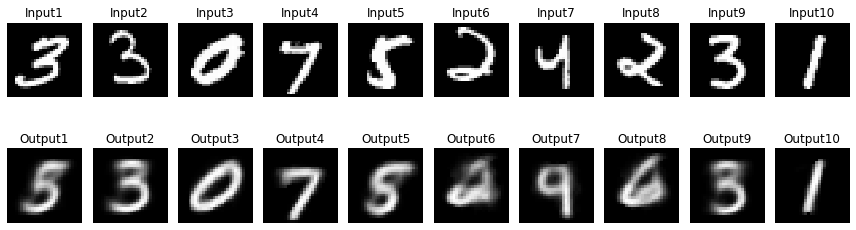

Iter:40000, Loss:66256.3984 (Recon:62731.6016, KLD:3524.7961)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

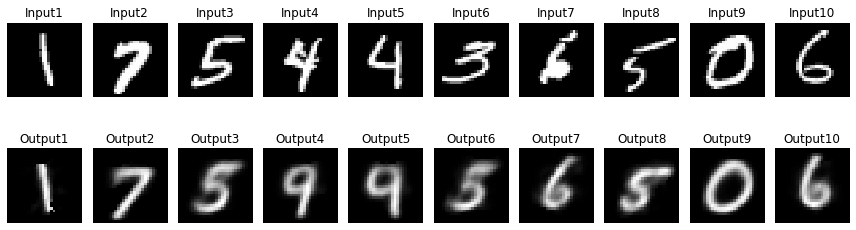

result was saved to >> result/VAE_mnist_result_iter40000.jpg
Iter:41000, Loss:61918.5781 (Recon:58396.6172, KLD:3521.9595)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

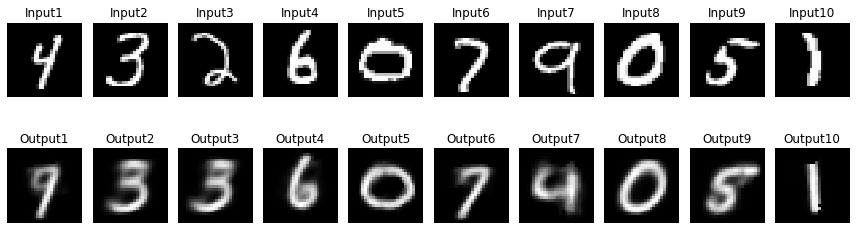

Iter:42000, Loss:62484.6992 (Recon:58949.5000, KLD:3535.1987)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

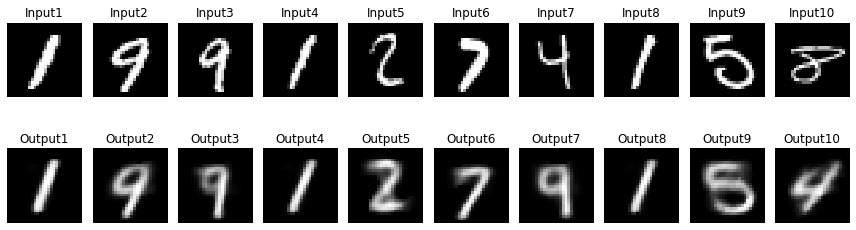

Iter:43000, Loss:65862.0391 (Recon:62326.0898, KLD:3535.9458)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

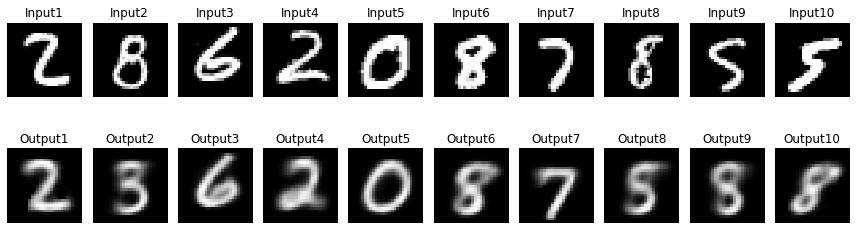

Iter:44000, Loss:64578.6641 (Recon:61082.4766, KLD:3496.1895)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

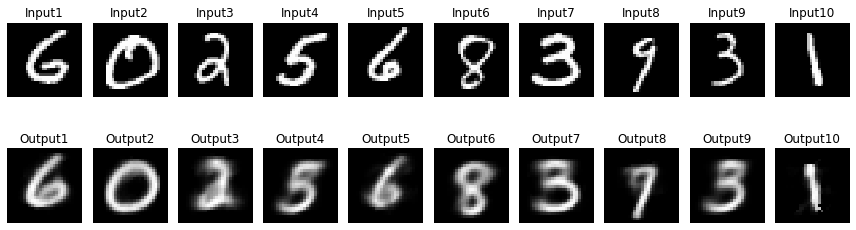

Iter:45000, Loss:63039.7266 (Recon:59541.8008, KLD:3497.9263)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

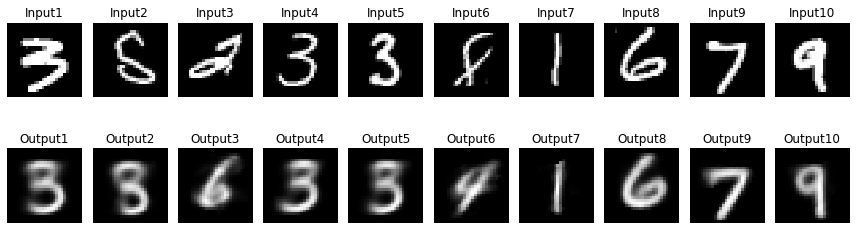

Iter:46000, Loss:65764.5000 (Recon:62202.9531, KLD:3561.5503)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

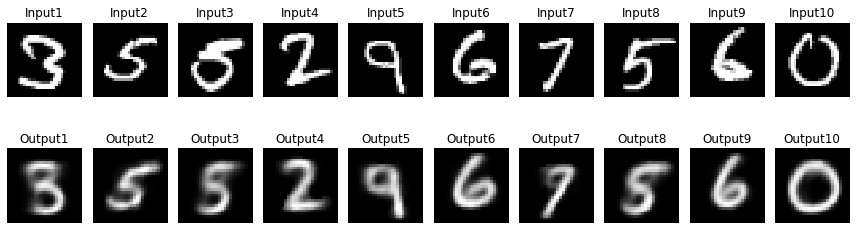

Iter:47000, Loss:63929.9414 (Recon:60375.1719, KLD:3554.7678)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

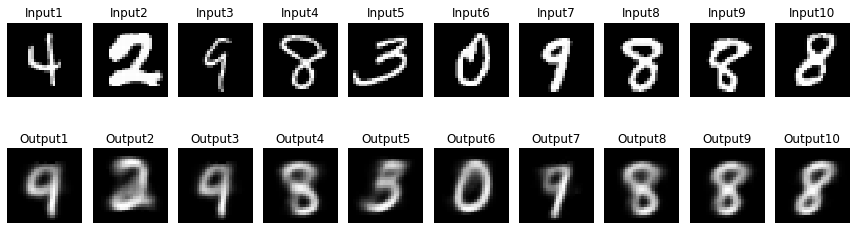

Iter:48000, Loss:68184.1875 (Recon:64598.9883, KLD:3585.1985)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

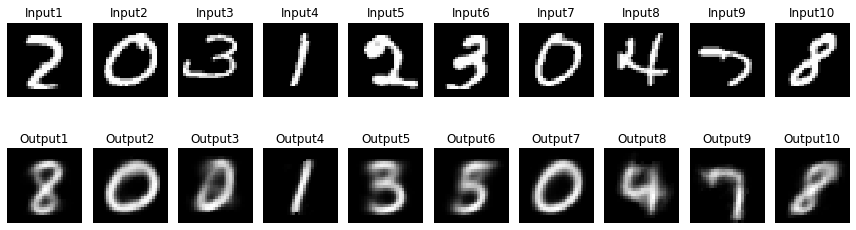

Iter:49000, Loss:64698.9219 (Recon:61180.7266, KLD:3518.1934)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

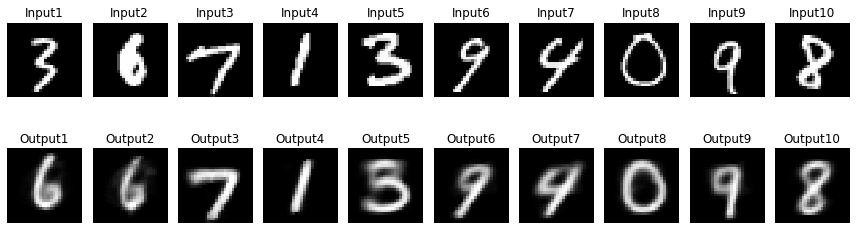

Iter:50000, Loss:61122.0156 (Recon:57501.4453, KLD:3620.5713)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

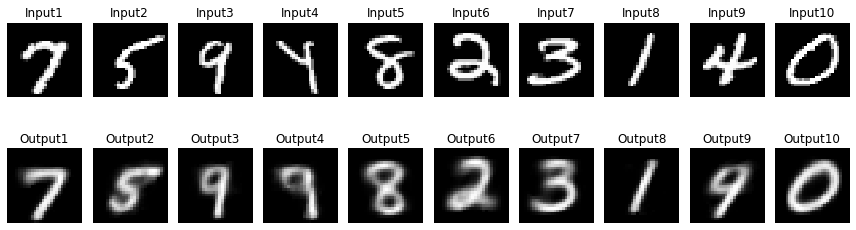

result was saved to >> result/VAE_mnist_result_iter50000.jpg
Iter:51000, Loss:64628.8711 (Recon:61079.5625, KLD:3549.3074)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

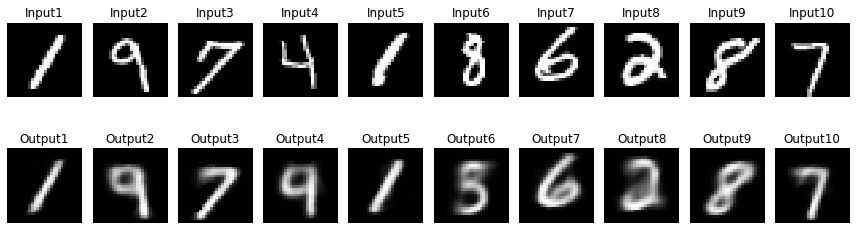

Iter:52000, Loss:62514.1562 (Recon:58957.2422, KLD:3556.9133)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

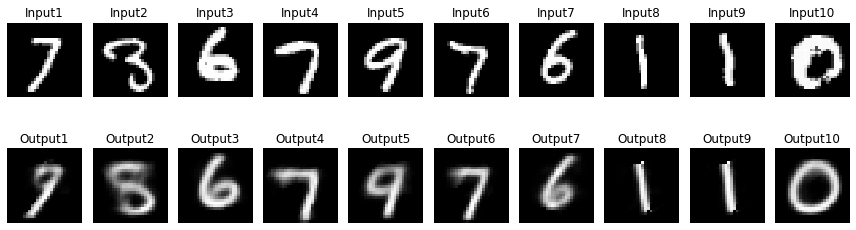

Iter:53000, Loss:62567.4492 (Recon:59030.0352, KLD:3537.4126)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

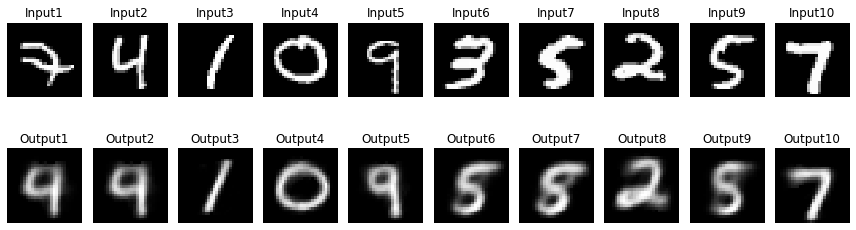

Iter:54000, Loss:65139.3438 (Recon:61568.4883, KLD:3570.8560)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

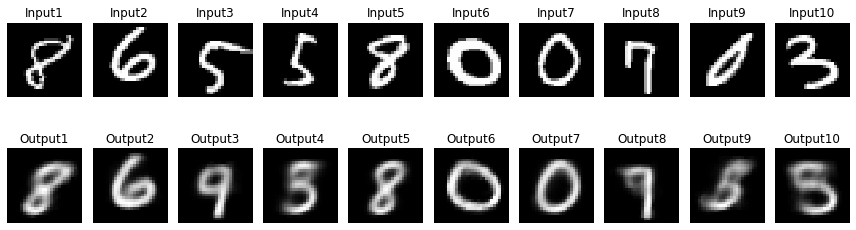

Iter:55000, Loss:64301.5859 (Recon:60701.2148, KLD:3600.3701)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

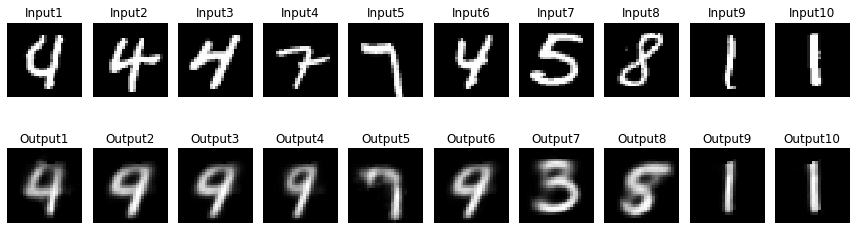

Iter:56000, Loss:64936.8477 (Recon:61337.1719, KLD:3599.6753)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

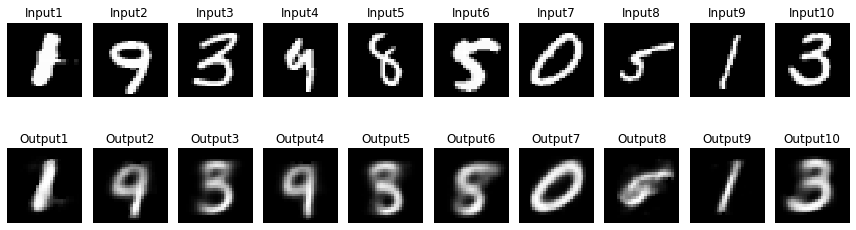

Iter:57000, Loss:65079.6094 (Recon:61505.4375, KLD:3574.1736)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

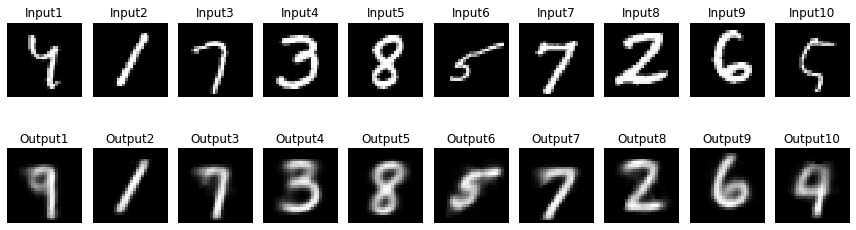

Iter:58000, Loss:64434.9688 (Recon:60922.7773, KLD:3512.1904)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

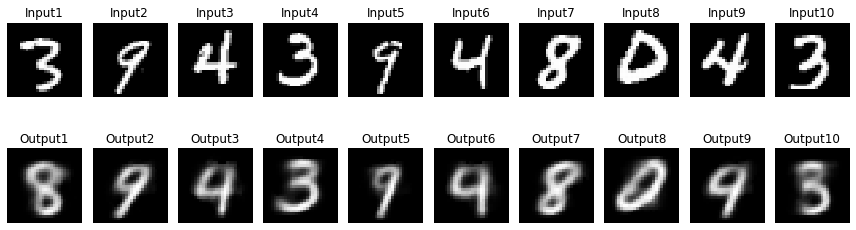

Iter:59000, Loss:63130.8672 (Recon:59559.1875, KLD:3571.6816)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

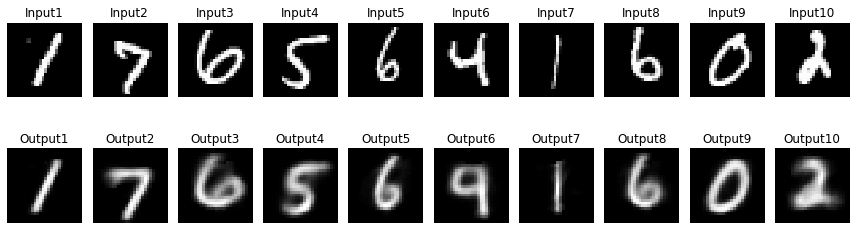

Iter:60000, Loss:64294.7656 (Recon:60709.9648, KLD:3584.8013)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

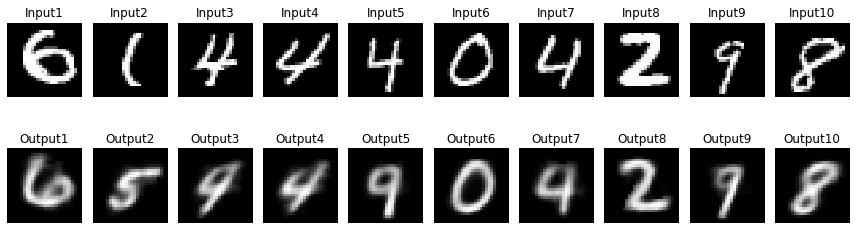

result was saved to >> result/VAE_mnist_result_iter60000.jpg
Iter:61000, Loss:65768.3672 (Recon:62118.0586, KLD:3650.3079)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

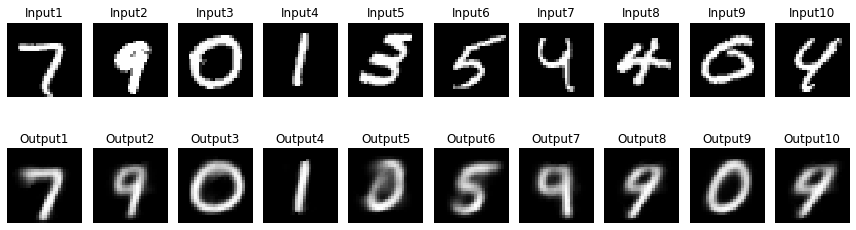

Iter:62000, Loss:61834.6094 (Recon:58235.6797, KLD:3598.9314)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

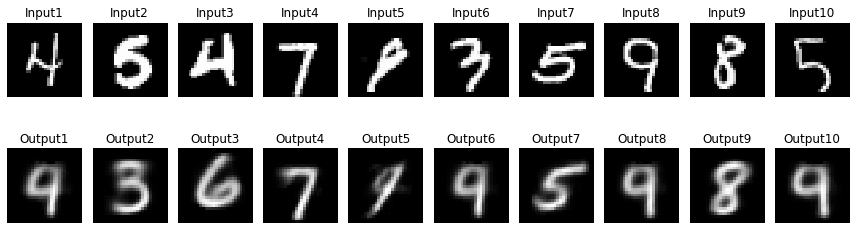

Iter:63000, Loss:63970.1562 (Recon:60353.8242, KLD:3616.3335)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

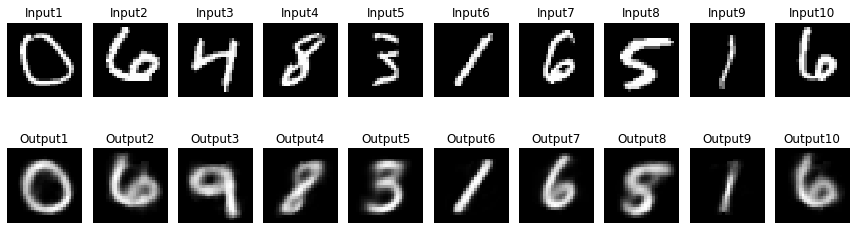

Iter:64000, Loss:62013.5898 (Recon:58389.4297, KLD:3624.1602)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

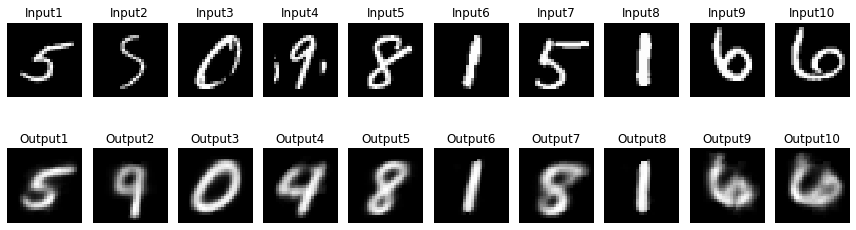

Iter:65000, Loss:63359.6680 (Recon:59774.6211, KLD:3585.0474)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

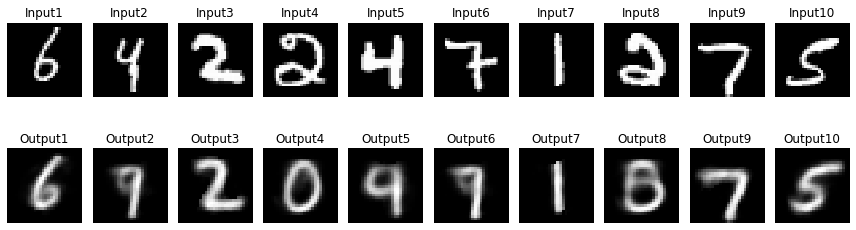

Iter:66000, Loss:64814.7227 (Recon:61221.2266, KLD:3593.4961)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

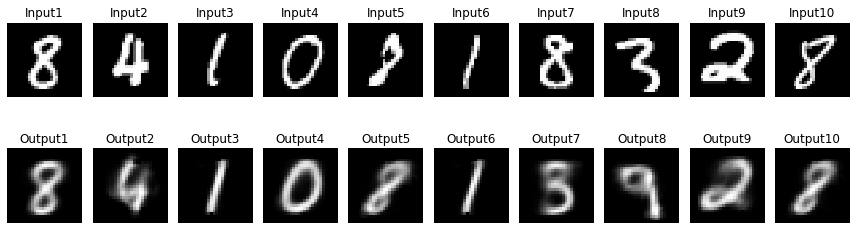

Iter:67000, Loss:62846.9062 (Recon:59219.1016, KLD:3627.8047)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

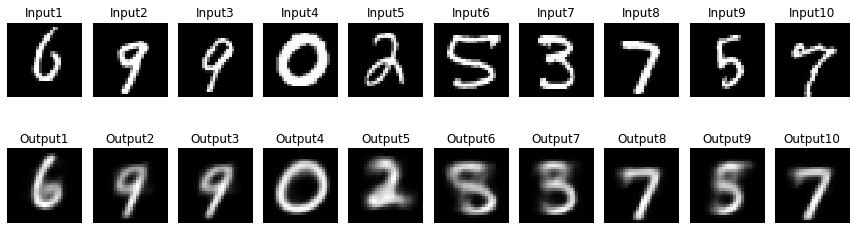

Iter:68000, Loss:63072.4258 (Recon:59448.0352, KLD:3624.3914)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

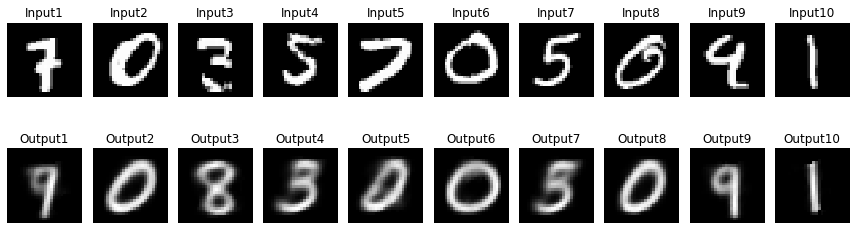

Iter:69000, Loss:64156.1094 (Recon:60542.2422, KLD:3613.8660)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

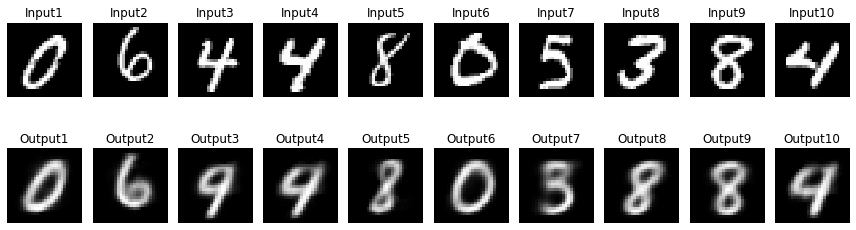

Iter:70000, Loss:63422.2734 (Recon:59767.2773, KLD:3654.9961)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

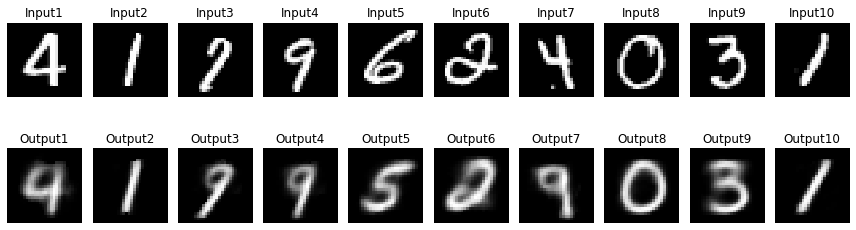

result was saved to >> result/VAE_mnist_result_iter70000.jpg
Iter:71000, Loss:63273.1094 (Recon:59658.5977, KLD:3614.5100)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

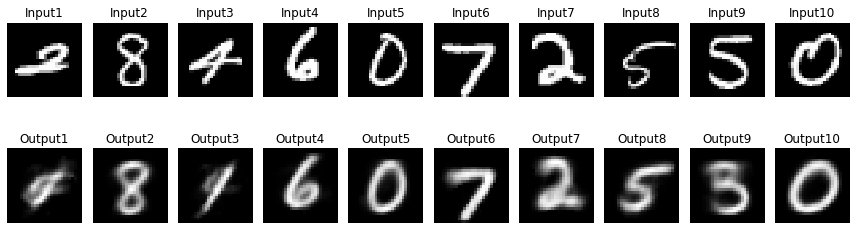

Iter:72000, Loss:63287.2617 (Recon:59656.3984, KLD:3630.8635)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

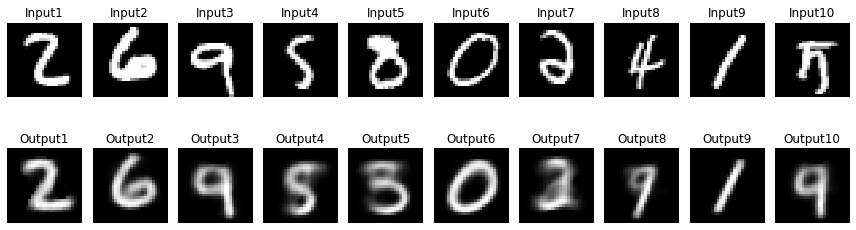

Iter:73000, Loss:62850.5742 (Recon:59246.3086, KLD:3604.2666)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

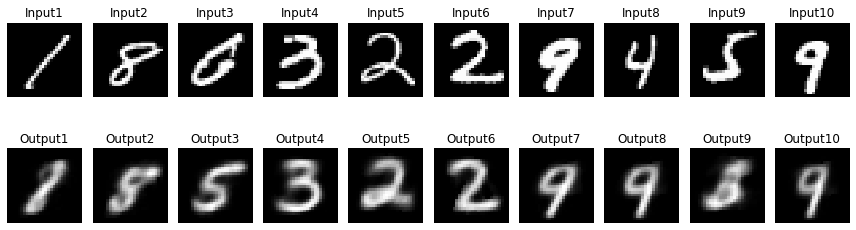

Iter:74000, Loss:66048.4453 (Recon:62430.2344, KLD:3618.2144)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

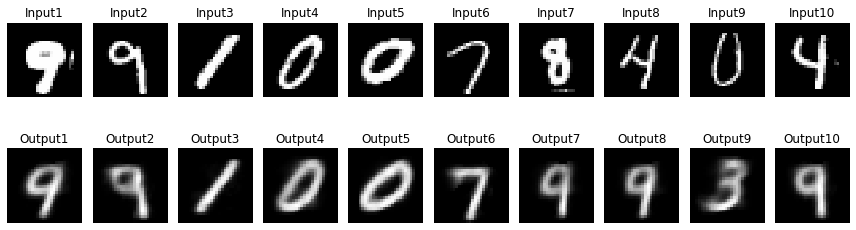

Iter:75000, Loss:64479.9648 (Recon:60912.3398, KLD:3567.6243)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

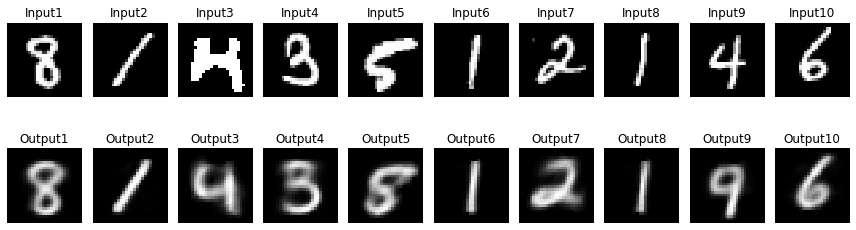

Iter:76000, Loss:64647.3008 (Recon:61032.1016, KLD:3615.1982)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

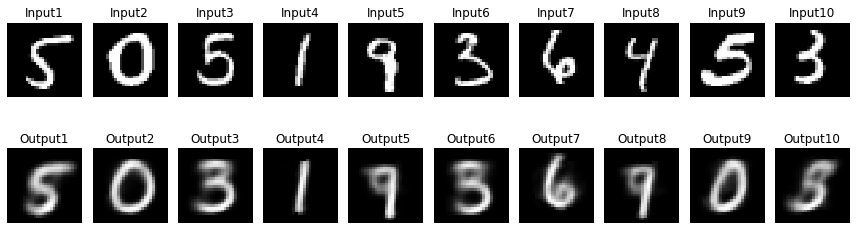

Iter:77000, Loss:63149.9961 (Recon:59566.3789, KLD:3583.6189)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

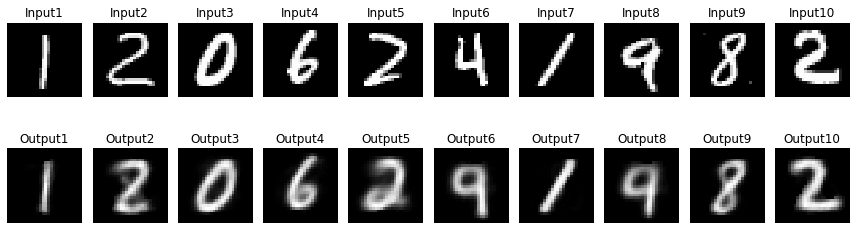

Iter:78000, Loss:63196.9219 (Recon:59560.3906, KLD:3636.5322)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

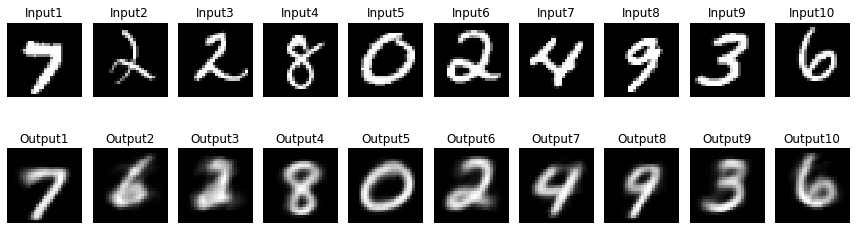

Iter:79000, Loss:60931.5000 (Recon:57335.4102, KLD:3596.0889)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

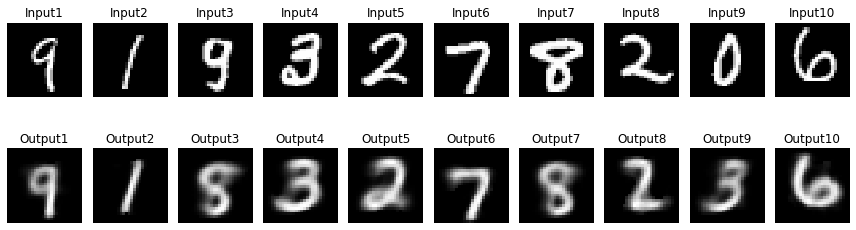

Iter:80000, Loss:64322.1953 (Recon:60720.0352, KLD:3602.1602)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

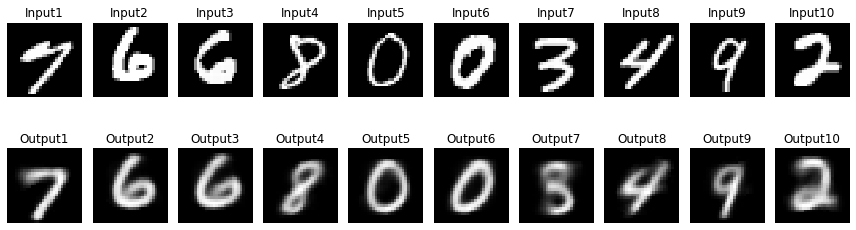

result was saved to >> result/VAE_mnist_result_iter80000.jpg
Iter:81000, Loss:63627.6562 (Recon:59968.1680, KLD:3659.4863)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

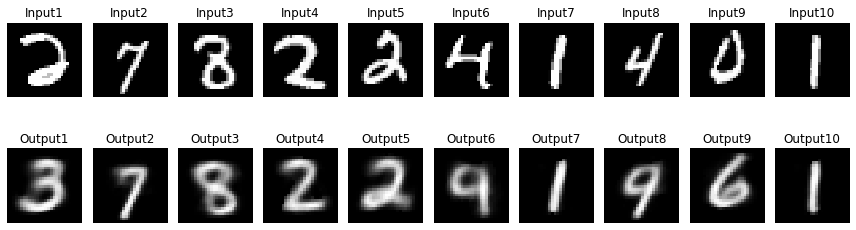

Iter:82000, Loss:62251.8281 (Recon:58602.6914, KLD:3649.1387)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

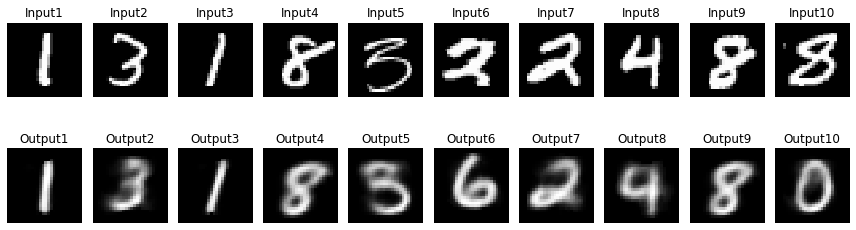

Iter:83000, Loss:61893.2695 (Recon:58284.2969, KLD:3608.9724)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

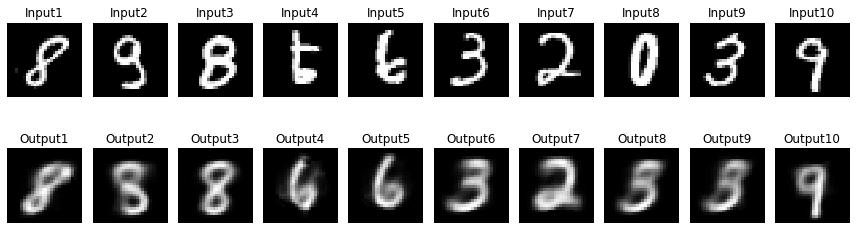

Iter:84000, Loss:63368.4219 (Recon:59764.4766, KLD:3603.9434)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

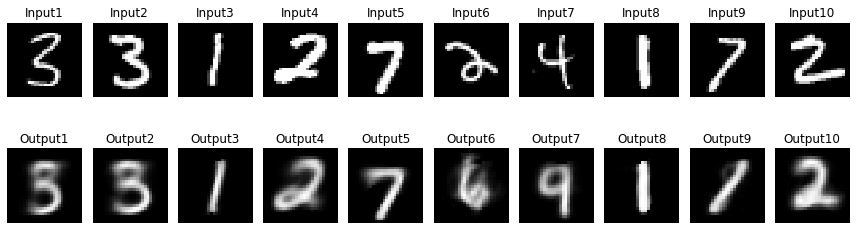

Iter:85000, Loss:62840.1094 (Recon:59232.8789, KLD:3607.2310)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

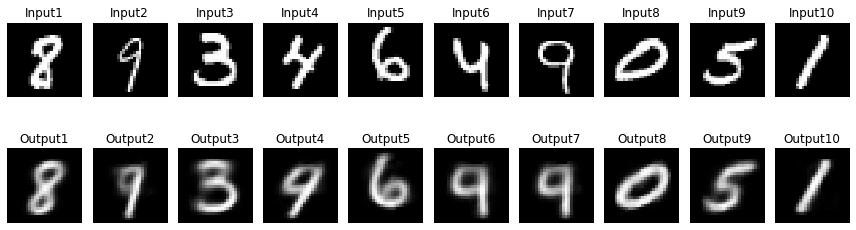

Iter:86000, Loss:65185.6406 (Recon:61542.0430, KLD:3643.5964)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

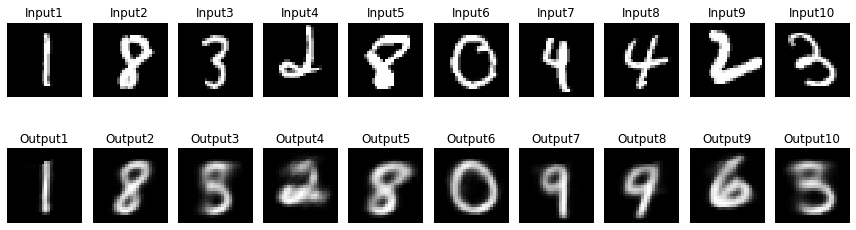

Iter:87000, Loss:62732.5391 (Recon:59057.0625, KLD:3675.4783)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

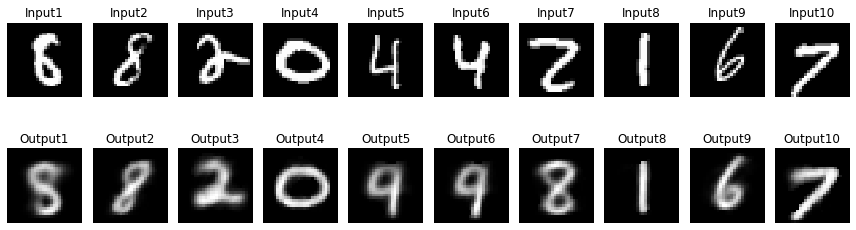

Iter:88000, Loss:62268.3086 (Recon:58605.1484, KLD:3663.1584)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

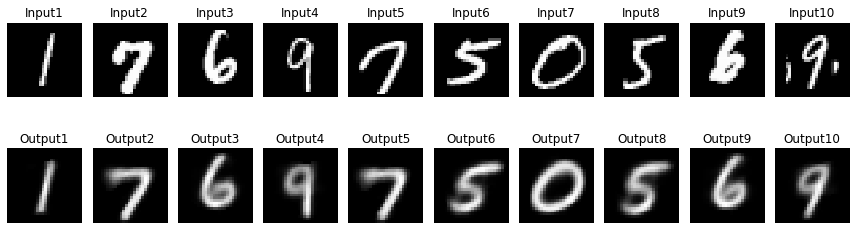

Iter:89000, Loss:64937.3750 (Recon:61259.9688, KLD:3677.4065)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

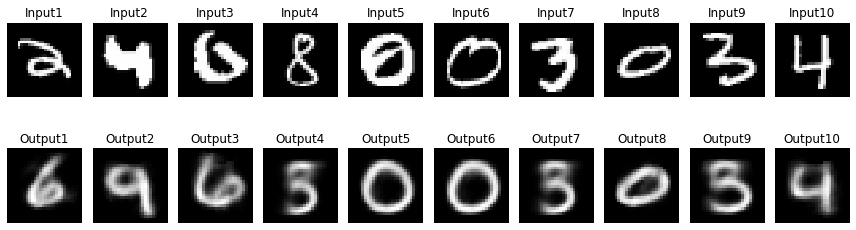

Iter:90000, Loss:60441.7109 (Recon:56818.5039, KLD:3623.2051)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

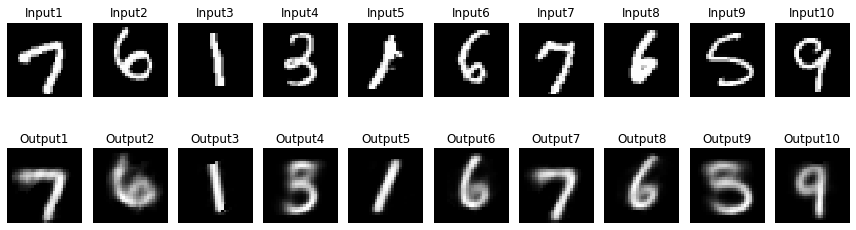

result was saved to >> result/VAE_mnist_result_iter90000.jpg
Iter:91000, Loss:64228.7930 (Recon:60630.6211, KLD:3598.1714)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

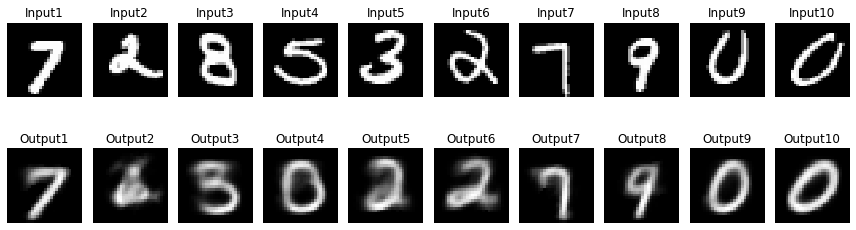

Iter:92000, Loss:63468.2461 (Recon:59784.7930, KLD:3683.4531)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

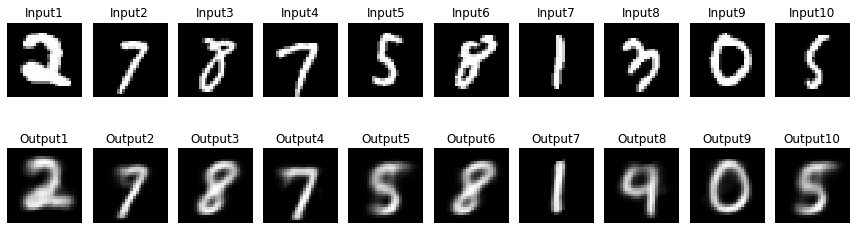

Iter:93000, Loss:63042.1016 (Recon:59433.1445, KLD:3608.9551)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

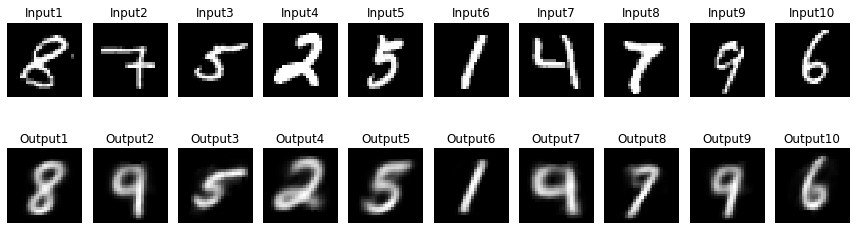

Iter:94000, Loss:63977.2617 (Recon:60326.1953, KLD:3651.0667)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

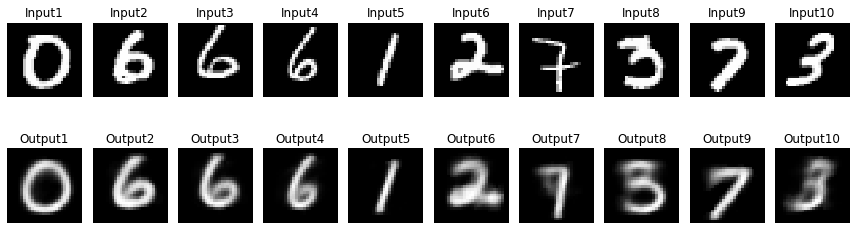

Iter:95000, Loss:62029.4023 (Recon:58399.8516, KLD:3629.5500)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

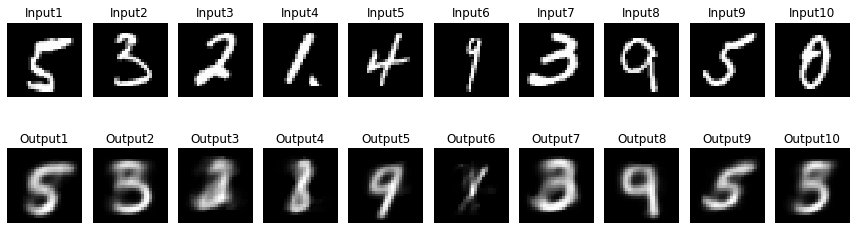

Iter:96000, Loss:63536.2344 (Recon:59893.1523, KLD:3643.0835)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

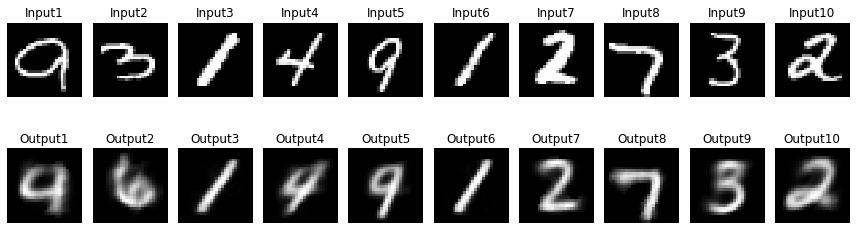

Iter:97000, Loss:62434.6992 (Recon:58753.6367, KLD:3681.0637)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

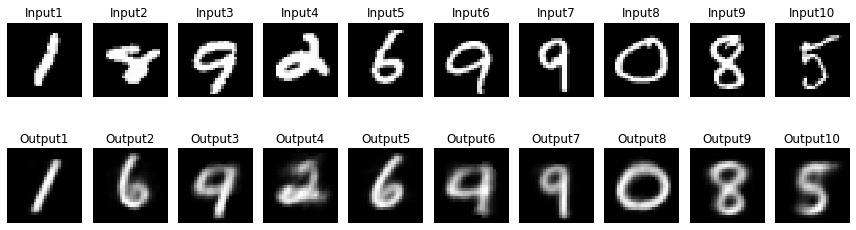

Iter:98000, Loss:62888.7578 (Recon:59204.1875, KLD:3684.5713)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

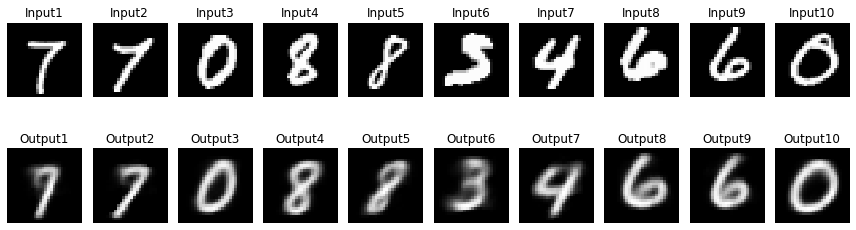

Iter:99000, Loss:65188.9297 (Recon:61533.9609, KLD:3654.9683)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

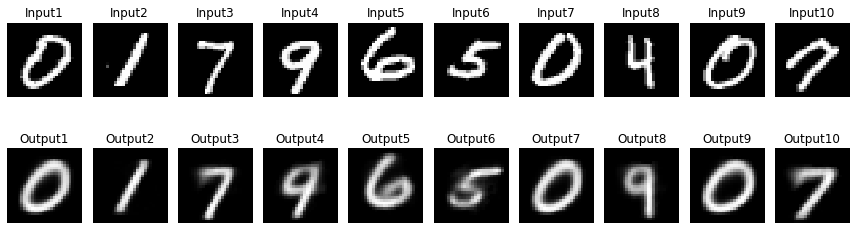

Iter:100000, Loss:63877.4180 (Recon:60243.8086, KLD:3633.6079)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

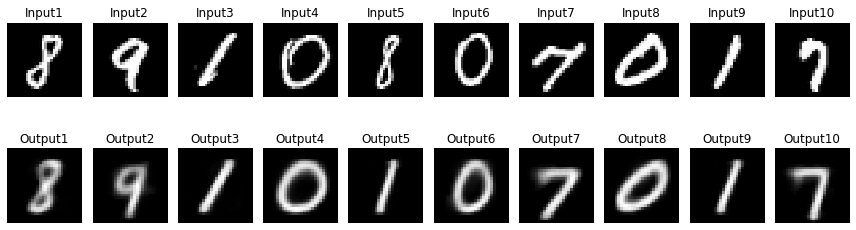

result was saved to >> result/VAE_mnist_result_iter100000.jpg
final paramters were saved toE >> models/VAE_mnist_E_final.pt, D >> models/VAE_mnist_D_final.pt
loss was saved to >> result/VAE_mnist_loss.txt


In [4]:
# train
def train():
    # model
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)
    model = torch.nn.Sequential(model_encoder, model_sampler, model_decoder)
    
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)
    
    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    train_Xs = trainset.data.numpy()
    train_ts = trainset.targets
    
    print('training data : ', train_Xs.shape)

    # training
    mbi = 0
    train_N = len(train_Xs)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss = []
    list_loss_RECONSTRUCTION = []
    list_loss_KLD = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # get minibatch
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # train
        opt.zero_grad()

        # sample X, y
        Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.INPUT_MODE, 
                                    hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION),
                          dtype=torch.float).to(cfg.DEVICE)
        #ts = torch.tensor(train_ts[mb_ind], dtype=torch.float).to(device)

        # forward
        mu, sigma = model_encoder(Xs)
        z = model_sampler([mu, sigma])
        ys = model_decoder(z)
        
        # loss
        loss_recon = cfg.TRAIN.LOSS_FUNCTION(ys, Xs.view(cfg.TRAIN.MINIBATCH, -1))
        
        # loss KLDivergence
        loss_kld = loss_KLDivergence(mu, sigma)
        loss = loss_recon + cfg.VAE_KLD_BALANCE * loss_kld

        # update
        loss.backward()
        opt.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss = loss.item()
        _loss_recon = loss_recon.item()
        _loss_kld = loss_kld.item()

        if (i + 1) % cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
                list_loss_RECONSTRUCTION.append(_loss_recon)
                list_loss_KLD.append(_loss_kld)
    
        # display training state
        if (i + 1) % cfg.TRAIN.DISPLAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f} (Recon:{:.4f}, KLD:{:.4f})'.format(i + 1, _loss, _loss_recon, _loss_kld))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path_E = cfg.TRAIN.MODEL_E_SAVE_PATH.format('iter{}'.format(i + 1))
            save_path_D = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model_encoder.state_dict(), save_path_E)
            torch.save(model_decoder.state_dict(), save_path_D)
            print('save E >> {}, D >> {}'.format(save_path_E, save_path_D))

        # show process result
        if (cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW != False) and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW == 0):
            result_show(
                model, Xs, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=False, show=True, cmap=cfg.OUTPUT_CMAP)
            
        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                model, Xs, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=True, show=False, cmap=cfg.OUTPUT_CMAP)

    save_path_E = cfg.TRAIN.MODEL_E_SAVE_PATH.format('final')
    save_path_D = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(model_encoder.state_dict(), save_path_E)
    torch.save(model_decoder.state_dict(), save_path_D)
    print('final paramters were saved toE >> {}, D >> {}'.format(save_path_E, save_path_D))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'loss_reconstruction' : list_loss_RECONSTRUCTION, 
                           'loss_KLD' : list_loss_KLD})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
VAE Encoder
- Input : 28 x 28 x 1
- encoder 1 : 784 > 64
- encoder 2 : 64 > 32
- encoder output : 32 > 2
--------------------
VAE Decoder
- Input : 2
- decoder 2 : 32 > 64
- decoder 1 : 64 > 784
- Output : (28 x 28 x 1)
--------------------


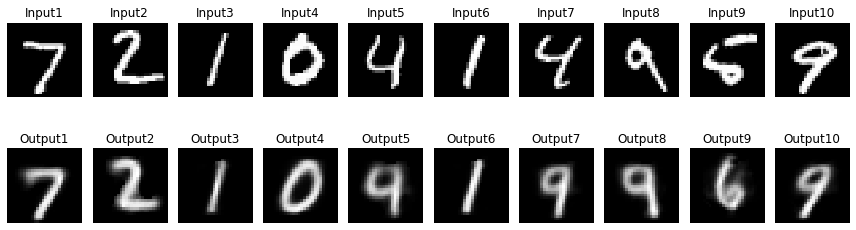

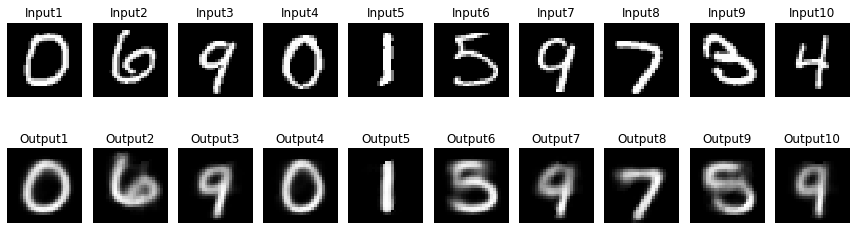

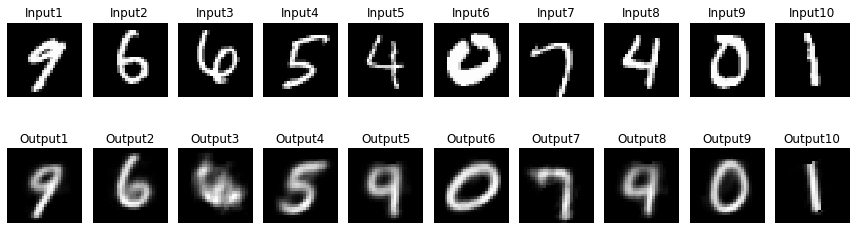

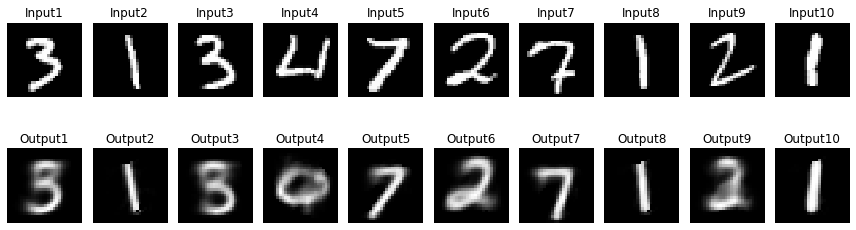

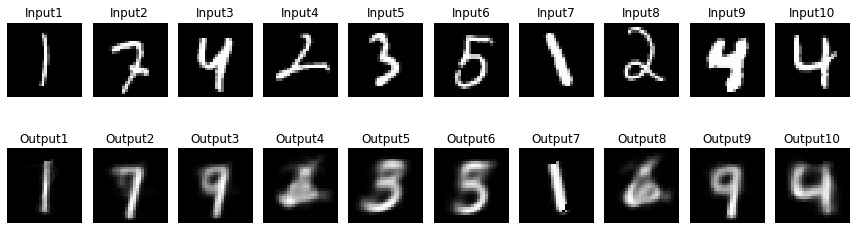

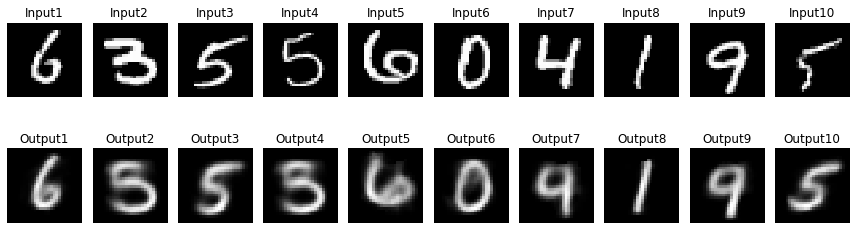

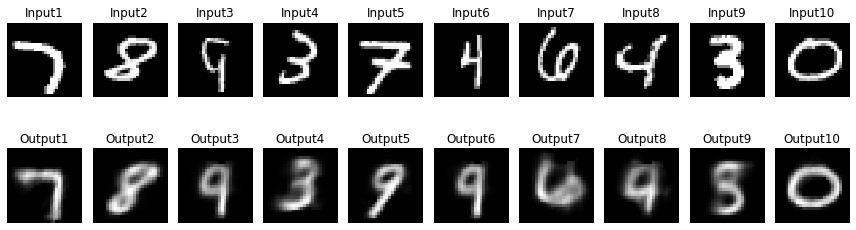

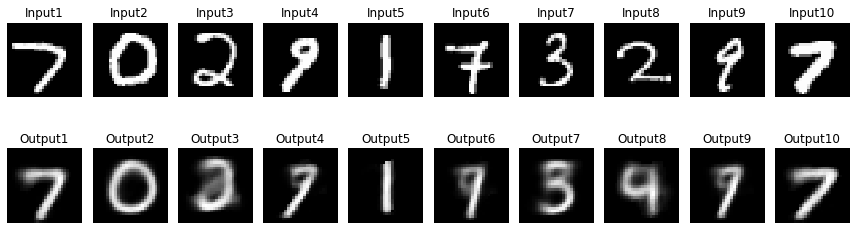

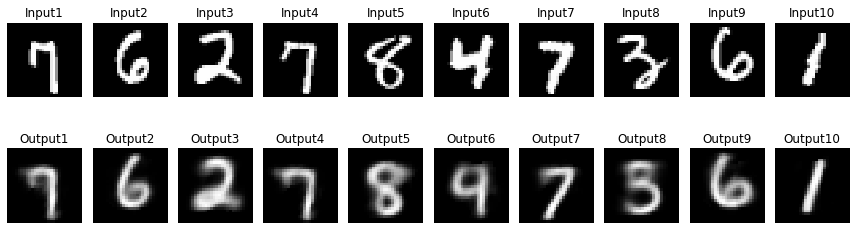

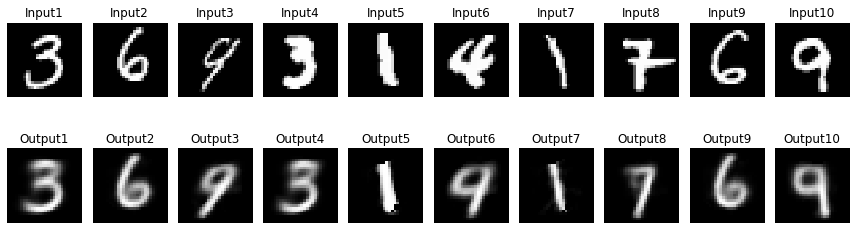

In [60]:
# test
def test():
    #print('-' * 20　+ '\ntest function\n' + '-' * 20)
    
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)
    model = torch.nn.Sequential(model_encoder, model_sampler, model_decoder)
    
    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    #path_dict = data_load(cfg, train=False, hf=False, vf=False, rot=False)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']
    
    trainset = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    train_Xs = trainset.data.numpy()
    train_ts = trainset.targets
    
    Test_Num = min(len(train_Xs), cfg.TEST.MAX_SAMPLES)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for i in range(0, Test_Num, cfg.TEST.MINIBATCH):
            mb_ind = np.arange(i, min(i + cfg.TEST.MINIBATCH, Test_Num))
            
            # sample X, y
            Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.INPUT_MODE, hf=False, vf=False, rot=False), dtype=torch.float).to(cfg.DEVICE)           

            result_show(model, Xs, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), 
                        save=cfg.TEST.RESULT_SAVE, show=True, cmap=cfg.OUTPUT_CMAP)

test()

## Latent Space

--------------------
VAE Encoder
- Input : 28 x 28 x 1
- encoder 1 : 784 > 64
- encoder 2 : 64 > 32
- encoder output : 32 > 2
--------------------
VAE Decoder
- Input : 2
- decoder 2 : 32 > 64
- decoder 1 : 64 > 784
- Output : (28 x 28 x 1)
--------------------


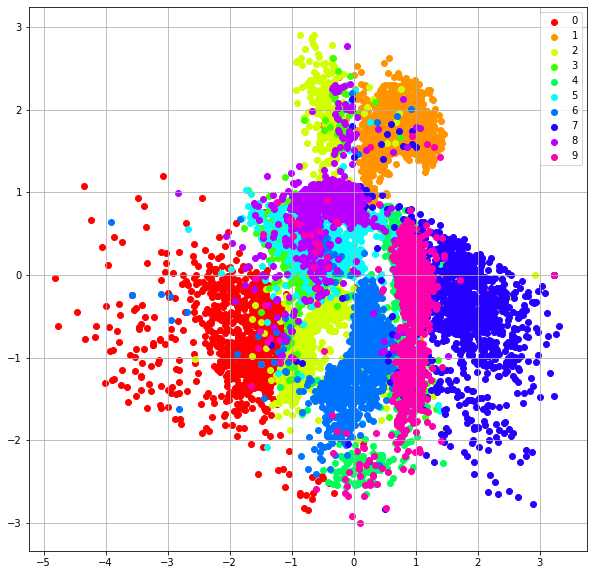

In [63]:
import matplotlib.cm

def latent_show():
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)

    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model_encoder.eval()
    model_sampler.eval()
    model_decoder.eval()

    plt.figure(figsize=[10, 10])
    
    colors = np.array([matplotlib.cm.hsv(i / cfg.CLASS_NUM) for i in range(cfg.CLASS_NUM)])
    
    mb = 512
    
    testset = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    test_Xs = testset.data.numpy()
    test_ts = testset.targets
    
    Test_Num = len(test_Xs)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for class_i in range(cfg.CLASS_NUM):
            _test_Xs = test_Xs[test_ts == class_i]

            Test_Num = len(_test_Xs)
            
            z1 = np.ndarray(shape=1)
            z2 = np.ndarray(shape=1)
            
            for i in range(0, Test_Num, mb):
                mb_ind = np.arange(i, min(i + mb, Test_Num))

                # sample X, y
                Xs = torch.tensor(preprocess(_test_Xs[mb_ind], cfg, cfg.INPUT_MODE, hf=False, vf=False, rot=False), dtype=torch.float).to(cfg.DEVICE)           

                # forward
                mu, sigma = model_encoder(Xs)
                z = model_sampler([mu, sigma])
                
                z1 = np.append(z1, z[:, 0])
                z2 = np.append(z2, z[:, 1])

            plt.scatter(z1, z2, c=[colors[class_i]], label=class_i)
    
    plt.grid()
    plt.legend()
    plt.savefig('result/vae_latent_show.png')
    plt.show()
    
latent_show()

## Latent control

--------------------
VAE Encoder
- Input : 28 x 28 x 1
- encoder 1 : 784 > 64
- encoder 2 : 64 > 32
- encoder output : 32 > 2
--------------------
VAE Decoder
- Input : 2
- decoder 2 : 32 > 64
- decoder 1 : 64 > 784
- Output : (28 x 28 x 1)
--------------------


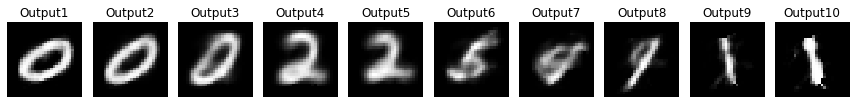

In [87]:
def latent_control():
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)

    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model_encoder.eval()
    model_sampler.eval()
    model_decoder.eval()
    
    plt.figure(figsize=[12, 12])
    
    # split number (show image number)
    show_num = 10

    # latent lower and upper bound
    z1_lower, z1_upper = -2, 2
    z2_lower, z2_upper = -2, 2

    div1 = (z1_upper - z1_lower) / show_num
    div2 = (z2_upper - z2_lower) / show_num
    
    z1s = np.arange(z1_lower, z1_upper + div1, div1)
    z2s = np.arange(z2_lower, z2_upper + div2, div2)
    
    with torch.no_grad():
        for i in range(show_num):
            # get latent vector
            z = [[z1s[i], z2s[i]]]
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            # decode latent vector
            ys = model_decoder(z).detach().cpu().numpy()
            ys = (ys * 127.5 + 127.5).astype(np.uint8)
            ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])

            if cfg.OUTPUT_CHANNEL == 1:
                ys = ys[:, 0]
            else:
                ys = ys.transpose(0, 2, 3, 1)

            # show output
            _y = ys[0]
            plt.subplot(1, show_num, i + 1)
            plt.imshow(_y, cmap=cfg.OUTPUT_CMAP)
            plt.axis('off')
            plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    plt.savefig('result/vae_latent_change.png')
    plt.show()
    
latent_control()

## Show Latent map

--------------------
VAE Encoder
- Input : 28 x 28 x 1
- encoder 1 : 784 > 64
- encoder 2 : 64 > 32
- encoder output : 32 > 2
--------------------
VAE Decoder
- Input : 2
- decoder 2 : 32 > 64
- decoder 1 : 64 > 784
- Output : (28 x 28 x 1)
--------------------


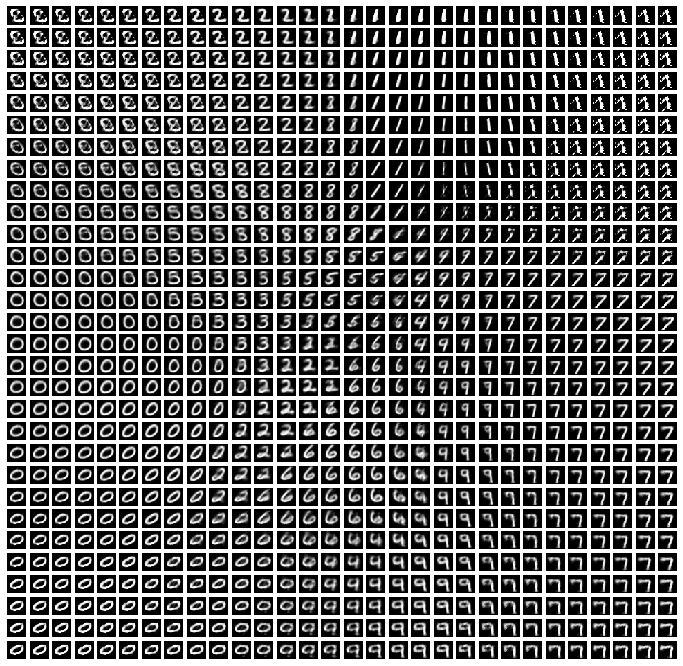

In [102]:
def latent_map():
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)

    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model_encoder.eval()
    model_sampler.eval()
    model_decoder.eval()

    plt.figure(figsize=[12, 12])
    
    # split number (show image number)
    z1_num = 30
    z2_num = 30

    # latent lower and upper bound
    z1_lower, z1_upper = -3, 3
    z2_lower, z2_upper = -3, 3
    
    div1 = (z1_upper - z1_lower) / z1_num
    div2 = (z2_upper - z2_lower) / z2_num
    
    z1s = np.arange(z1_lower, z1_upper + div1, div1)
    z2s = np.arange(z2_lower, z2_upper + div2, div2)
    
    with torch.no_grad():
        for i in range(z2_num):
            z = [[_z1, z2s[i]] for _z1 in z1s]

            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
                
            # decode latent vector
            ys = model_decoder(z).detach().cpu().numpy()
            ys = (ys * 127.5 + 127.5).astype(np.uint8)
            ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])

            if cfg.OUTPUT_CHANNEL == 1:
                ys = ys[:, 0]
            else:
                ys = ys.transpose(0, 2, 3, 1)

            # show output
            for j in range(z1_num):
                _y = ys[j]
                plt.subplot(z2_num, z1_num, j + (z2_num - 1 - i) * z1_num + 1)
                plt.imshow(_y, cmap=cfg.OUTPUT_CMAP)
                plt.axis('off')
            
    plt.show()
    
latent_map()